## Unsupervised Learning - Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

## Getting Started

In this project, we will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt
# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("../input/customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


In [2]:
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

def cluster_results(reduced_data, preds, centers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Plot transformed sample points 
	ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
	           s = 150, linewidth = 4, color = 'black', marker = 'x');

	# Set plot title
	ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");


def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute

    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax
    

def channel_results(reduced_data, outliers, pca_samples):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
	Data is labeled by "Channel" and cues added for student-selected sample data
	'''

	# Check that the dataset is loadable
	try:
	    full_data = pd.read_csv("../input/customers.csv")
	except:
	    print("Dataset could not be loaded. Is the file missing?")       
	    return False

	# Create the Channel DataFrame
	channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
	channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
	labeled = pd.concat([reduced_data, channel], axis = 1)
	
	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned Channel
	labels = ['Hotel/Restaurant/Cafe', 'Retailer']
	grouped = labeled.groupby('Channel')
	for i, channel in grouped:   
	    channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);
	    
	# Plot transformed sample points   
	for i, sample in enumerate(pca_samples):
		ax.scatter(x = sample[0], y = sample[1], \
	           s = 200, linewidth = 3, color = 'black', marker = 'o', facecolors = 'none');
		ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), alpha = 1, s=125);

	# Set plot title
	ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");

In [3]:
# Print some sample data
display(data.head())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## Data Exploration

In this section, we will begin exploring the data through visualizations and code to understand how each feature is related to the others. We will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

In [4]:
# Display Data Info
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 6 columns):
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicatessen        440 non-null int64
dtypes: int64(6)
memory usage: 20.7 KB


None

From the above info we can see that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Also there are no NULL values in any of the data values. Run the code block below to observe a statistical description of the dataset.  Consider what each category represents in terms of products you could purchase.

In [5]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [6]:
# Select three indices of your choice you wish to sample from the dataset
np.random.seed(2018)
indices = np.random.randint(low = 0, high = 441, size = 3)
print("Indices of Samples => {}".format(indices))

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("\nChosen samples of wholesale customers dataset:")
display(samples)

Indices of Samples => [250 102 226]

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,3191,1993,1799,1730,234,710
1,2932,6459,7677,2561,4573,1386
2,20782,5921,9212,1759,2568,1553


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  

* What kind of establishment (customer) could each of the three samples you've chosen represent?

**Hint:** Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant. You can use the mean values for reference to compare your samples with. The mean values are as follows:

* Fresh: 12000.2977
* Milk: 5796.2
* Grocery: 7951.3
* Detergents_paper: 2881.4
* Delicatessen: 1524.8

Knowing this, how do your samples compare? Does that help in driving your insight into what kind of establishments they might be? 


**Answer:**

In [7]:
# Function to display the sample data vs the population mean for
# each of the categories
def sampl_pop_plotting(sample):
    fig, ax = plt.subplots(figsize=(10,5))
    
    index = np.arange(sample.count())
    bar_width = 0.3
    opacity_pop = 1
    opacity_sample = 0.3

    rect1 = ax.bar(index, data.mean(), bar_width,
                    alpha=opacity_pop, color='g',
                    label='Population Mean')
    
    rect2 = ax.bar(index + bar_width, sample, bar_width,
                    alpha=opacity_sample, color='k',
                    label='Sample')
    
    ax.set_xlabel('Categories')
    ax.set_ylabel('Total Purchase Cost')
    ax.set_title('Sample vs Population Mean')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(samples.columns)
    ax.legend(loc=0, prop={'size': 15})
    
    fig.tight_layout()
    plt.show()

In [8]:
# Display data for the first sample wrt to the population mean
display(samples.iloc[0] - data.mean())

Fresh              -8809.297727
Milk               -3803.265909
Grocery            -6152.277273
Frozen             -1341.931818
Detergents_Paper   -2647.493182
Delicatessen        -814.870455
dtype: float64

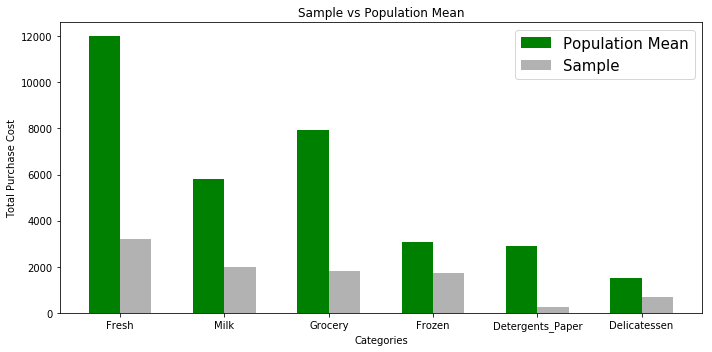

In [9]:
# Plot data for the first sample wrt to the population mean
sampl_pop_plotting(samples.iloc[0])

In [10]:
# Display data for the second sample wrt to the population mean
display(samples.iloc[1] - data.mean())

Fresh              -9068.297727
Milk                 662.734091
Grocery             -274.277273
Frozen              -510.931818
Detergents_Paper    1691.506818
Delicatessen        -138.870455
dtype: float64

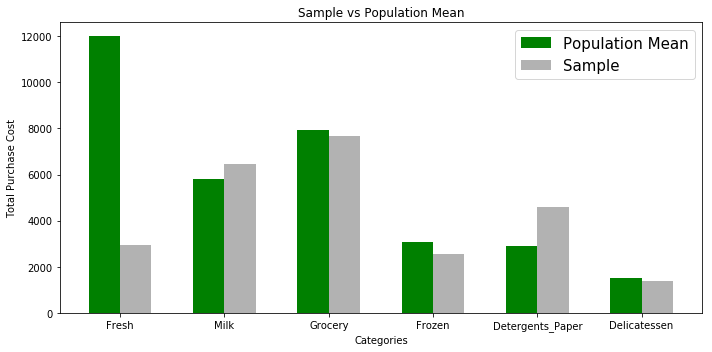

In [11]:
# Plot data for the second sample wrt to the population mean
sampl_pop_plotting(samples.iloc[1])

In [12]:
# Display data for the third sample wrt to the population mean
display(samples.iloc[2] - data.mean())

Fresh               8781.702273
Milk                 124.734091
Grocery             1260.722727
Frozen             -1312.931818
Detergents_Paper    -313.493182
Delicatessen          28.129545
dtype: float64

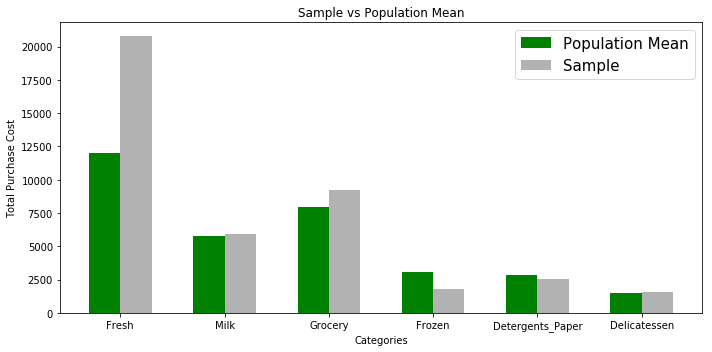

In [13]:
# Plot data for the third sample wrt to the population mean
sampl_pop_plotting(samples.iloc[2])

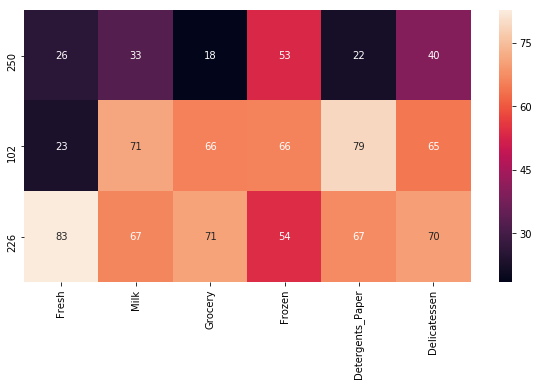

In [14]:
# percentile heatmap for sample points
percentiles_data = 100*data.rank(pct=True)
percentiles_samples = percentiles_data.iloc[indices]
plt.subplots(figsize=(10,5))
_ = sns.heatmap(percentiles_samples, annot=True)

**1. Sample 1 -** For the first sample we could see that the purchase cost of 'Fresh' and 'Frozen' are way less than the sample mean. Also the purchase cost of other categories is also less than the population mean. The establishment could be of a small cafe or hotel.

**2. Sample 2 -** For the second sample we could see that the purchase cost of 'Fresh' is way low than the population mean. This establishment has a purchase cost approximately equal to population mean for 'Milk', 'Grocery' and 'Frozen'. This indicates that this could be a supermarket or restaurant.

**3. Sample 3 -** For the third sample we could see that the purchase cost of all the categories is almost equal to the population mean except for 'Fresh' for which the purchase cost is very high. This establishment could be a retailer.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [15]:
def predict_one_feature(dropped_feature):
    # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    print("Dropping feature -> {}".format(dropped_feature))
    new_data = data.drop([dropped_feature], axis = 1)
    
    # Split the data into training and testing sets(0.25) using the given feature as the target
    # Set a random state.
    X_train, X_test, y_train, y_test = train_test_split(new_data, data[dropped_feature], test_size=0.25, random_state=0)
    
    # Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train, y_train)
    
    # Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print("Score for predicting '{}' using other features = {:.3f}\n".format(dropped_feature, score))

In [16]:
# Attempt to predict the score of 'Milk' using other features
predict_one_feature('Milk')

Dropping feature -> Milk
Score for predicting 'Milk' using other features = 0.366



In [17]:
print("Features in data -> {}\n".format(data.columns.values))

# Predict the score of each feature by dropping it and using other features
for cols in data.columns.values:
    predict_one_feature(cols)

Features in data -> ['Fresh' 'Milk' 'Grocery' 'Frozen' 'Detergents_Paper' 'Delicatessen']

Dropping feature -> Fresh
Score for predicting 'Fresh' using other features = -0.252

Dropping feature -> Milk
Score for predicting 'Milk' using other features = 0.366

Dropping feature -> Grocery
Score for predicting 'Grocery' using other features = 0.603

Dropping feature -> Frozen
Score for predicting 'Frozen' using other features = 0.254

Dropping feature -> Detergents_Paper
Score for predicting 'Detergents_Paper' using other features = 0.729

Dropping feature -> Delicatessen
Score for predicting 'Delicatessen' using other features = -11.664



### Question 2

* Which feature did you attempt to predict? 
* What was the reported prediction score? 
* Is this feature necessary for identifying customers' spending habits?

**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data. If you get a low score for a particular feature, that lends us to beleive that that feature point is hard to predict using the other features, thereby making it an important feature to consider when considering relevance.

**Answer:**

1. _Which feature did you attempt to predict?_ - 'Milk'. My intuition was that 'Milk' is one of the top features that could be better predicted using other features as it has a good correlation with 'Fresh' and 'Frozen'.
2. _What was the reported prediction score?_ - The reported score is 0.366
3. _Is this feature necessary for identifying customers' spending habits?_ - As we got a lower score for 'Milk' I think we should keep this as a necessary feature for identifying customer spending.

Below is the predicatability score for each of the features when they are dropped and other features are used for prediction.

1. 'Detergents_Paper' - 0.729
2. 'Grocery' - 0.603
3. 'Milk' - 0.366
4. 'Frozen' - 0.254
5. 'Fresh' - -0.252
6. 'Delicatessen' - -11.664

One surprising thing is that I predicted that the score for 'Fresh' would be around 0.3 but I can see that it is in Negative.

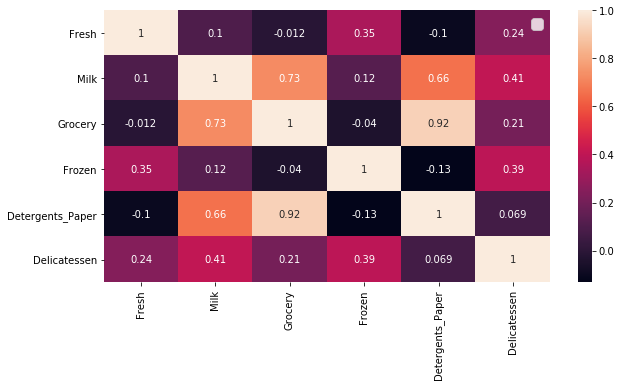

In [18]:
# Display the correlation heatmap
corr = data.corr()

plt.figure(figsize = (10,5))
ax = sns.heatmap(corr, annot=True)
ax.legend(loc=0, prop={'size': 15})

As we see that the 'Detergents_Paper' has a high correlation with 'Grocery' and 'Milk' and so is the high predicatability score.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

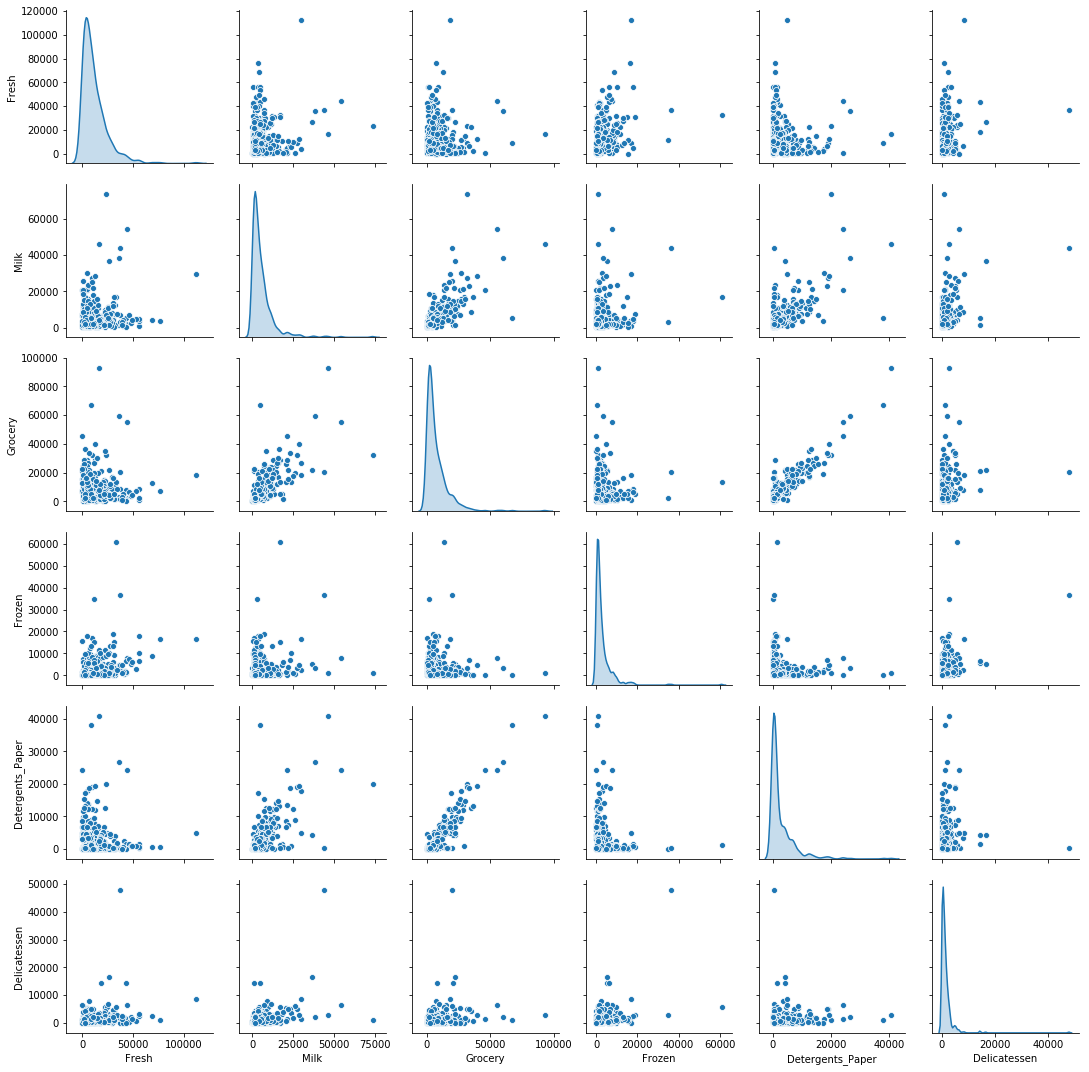

In [19]:
# Produce a scatter matrix for each pair of features in the data
_ = sns.pairplot(data, diag_kind = 'kde')

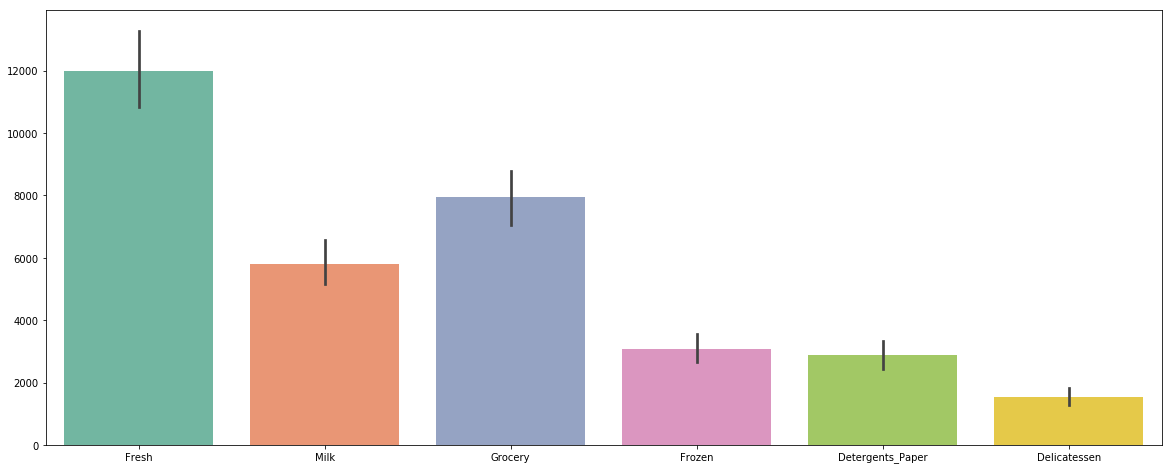

In [20]:
plt.figure(figsize = (20,8))
_ = sns.barplot(data=data, palette="Set2")

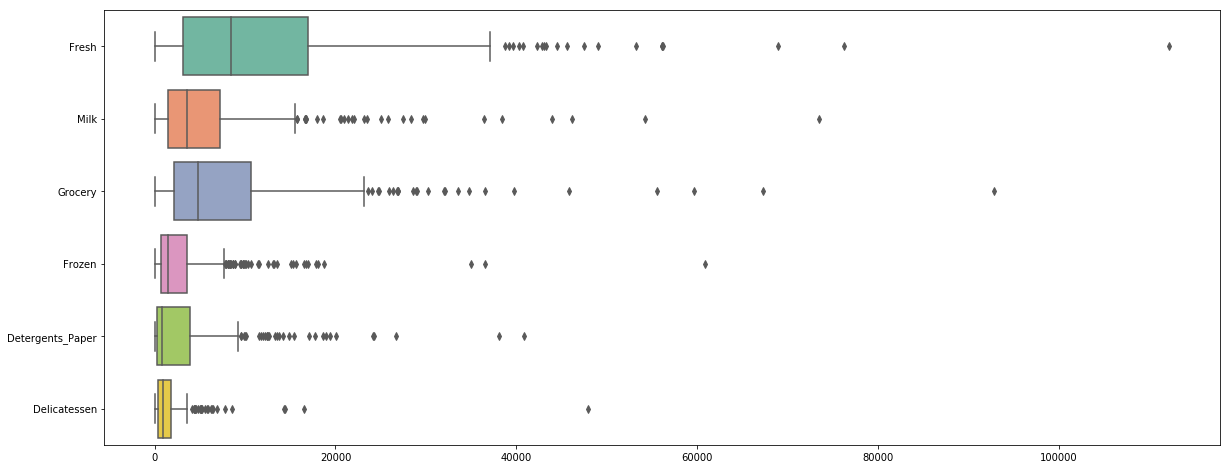

In [21]:
plt.figure(figsize = (20,8))
_ = sns.boxplot(data=data, orient='h', palette="Set2")

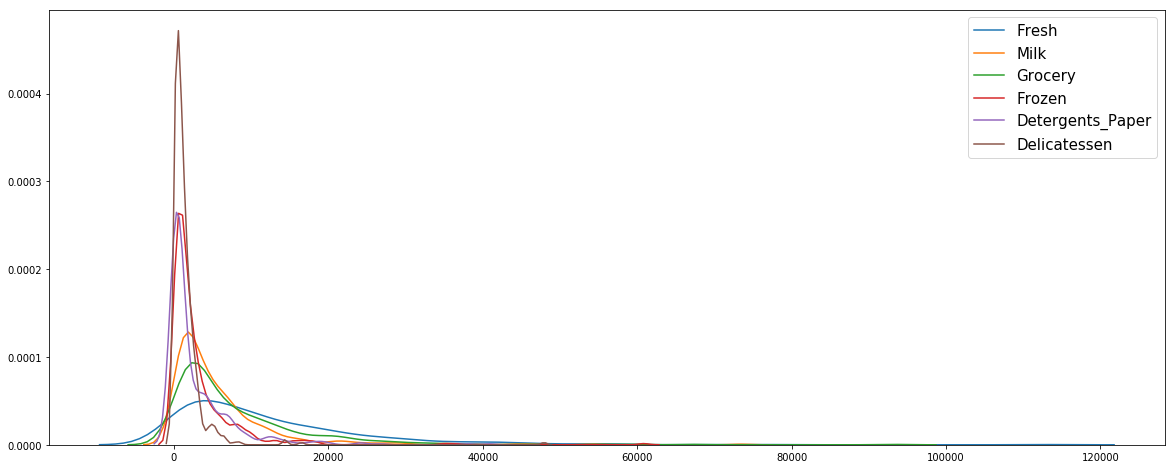

In [22]:
plt.figure(figsize = (20,8))

for cols in data.columns.values:
    ax = sns.kdeplot(data[cols])
    ax.legend(loc=0, prop={'size': 15})

### Question 3
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation? 
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
* How is the data for those features distributed?

**Hint:** Is the data normally distributed? Where do most of the data points lie? You can use [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to get the feature correlations and then visualize them using a [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html)(the data that would be fed into the heatmap would be the correlation values, for eg: `data.corr()`) to gain further insight.

**Answer:**

1. _Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well._ - From the above visualization we could clearly see that the data is not normally distributed  for any of the features. Most of the data for all the features lies near zero and is heavily right skewed. Also from the boxplot we could see that there are many outliers for each of the features. Moreover the range of values for each of the features vary a lot.
2. _Are there any pairs of features which exhibit some degree of correlation?_ - From the correlation heatmap we could see that
    * 'Detergents_Paper' and 'Grocery' has strong correlation (0.92)
    * 'Milk' and 'Grocery' has strong correlation (0.73)
    * 'Detergents_Paper' and 'Milk' has strong correlation (0.66)
3. _Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict?_ - My predicted feature 'Milk' has a strong correlation with two other features and could have been easily predicted. But there are even more stronger correlations that essentially brings down the feature 'Milk' a little low in the order.
4. _How is the data for those features distributed?_ - From the visualizations it is very clear that the data is not normally distributed. All the features are skewed to the right and most of the data values are centered near zero.

## Data Preprocessing
In this section, we will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

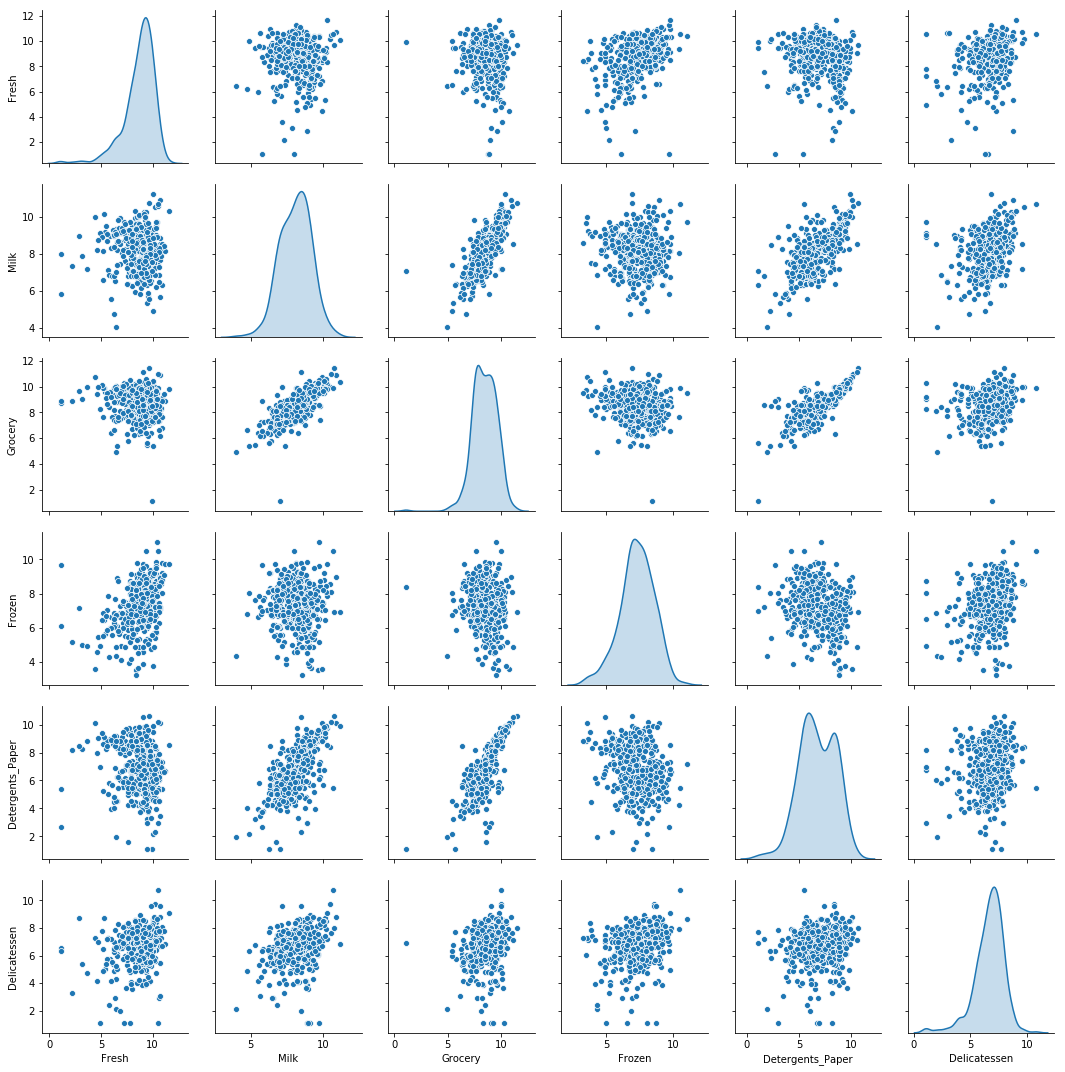

In [23]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
_ = sns.pairplot(log_data, diag_kind = 'kde')

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [24]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.068090,7.597396,7.494986,7.455877,5.455321,6.565265
1,7.983440,8.773230,8.945984,7.848153,8.427925,7.234177
2,9.941843,8.686261,9.128262,7.472501,7.850883,7.347944


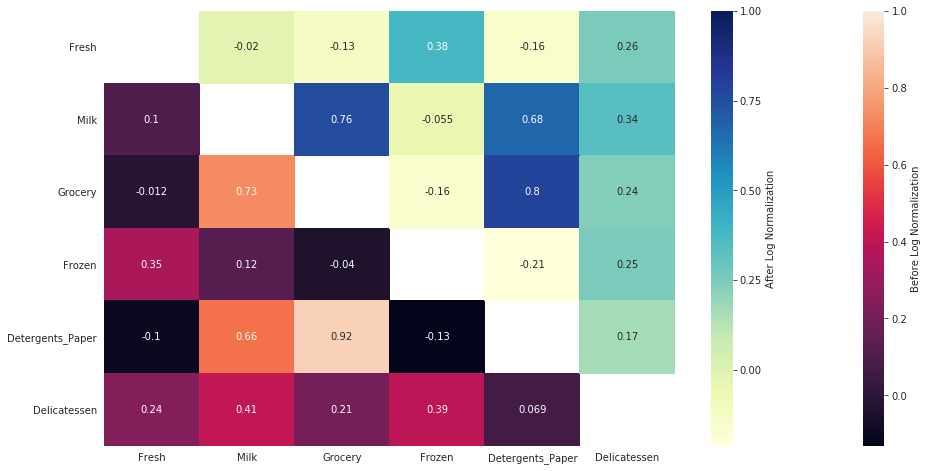

In [25]:
# Display the correlation heatmap
log_corr = log_data.corr()

f = plt.figure(figsize = (16,8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax1 = sns.heatmap(corr, annot=True, mask=mask, cbar_kws={'label': 'Before Log Normalization'})

mask2 = np.zeros_like(corr)
mask2[np.tril_indices_from(mask2)] = True
with sns.axes_style("white"):
    ax2 = sns.heatmap(log_corr, annot=True, mask=mask2, cmap="YlGnBu", cbar_kws={'label': 'After Log Normalization'})

After normalizing the data, correlations between the features have changed a little which is evident from the above visualization.

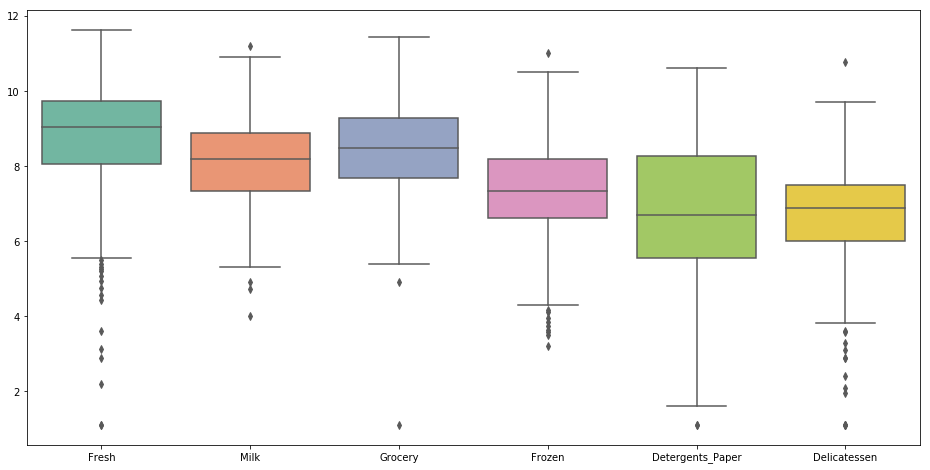

In [26]:
# boxplot on the logdata
plt.figure(figsize = (16,8))
_ = sns.boxplot(data=log_data, palette="Set2")

### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [27]:
outliers_list = []
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    outliers = list(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index.values)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    outliers_list.extend(outliers)
    
print("List of Outliers -> {}".format(outliers_list))
duplicate_outliers_list = list(set([x for x in outliers_list if outliers_list.count(x) >= 2]))
duplicate_outliers_list.sort()
print("\nList of Common Outliers -> {}".format(duplicate_outliers_list))

# Select the indices for data points you wish to remove
outliers  = duplicate_outliers_list

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


List of Outliers -> [65, 66, 81, 95, 96, 128, 171, 193, 218, 304, 305, 338, 353, 355, 357, 412, 86, 98, 154, 356, 75, 154, 38, 57, 65, 145, 175, 264, 325, 420, 429, 439, 75, 161, 66, 109, 128, 137, 142, 154, 183, 184, 187, 203, 233, 285, 289, 343]

List of Common Outliers -> [65, 66, 75, 128, 154]


### Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset? 
* If any data points were added to the `outliers` list to be removed, explain why.

** Hint: ** If you have datapoints that are outliers in multiple categories think about why that may be and if they warrant removal. Also note how k-means is affected by outliers and whether or not this plays a factor in your analysis of whether or not to remove them.

**Answer:**

1. _Are there any data points considered outliers for more than one feature based on the definition above?_ - Yes, there are 5 data points that are considered outliers for more than one feature based on the above analysis.
2. _Should these data points be removed from the dataset?_ - As these data points are considered outliers for multiple features we could remove them.
3. _If any data points were added to the `outliers` list to be removed, explain why._ - The above 5 data points that were outliers for more than one feature were removed from the data set so that we do not build a clustering model on the skewed data. We clearly know that clustering algorithms are sensitive to noisy data and outliers. As we use SSE to choose the cluster center, outiers will pull the center towards them and the cluster center will not be a proper representation of the data.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

Explained Variance Ratio => [0.44302505 0.26379218 0.1230638  0.10120908 0.04850196 0.02040793]

Explained Variance Ratio(csum) => [0.44302505 0.70681723 0.82988103 0.93109011 0.97959207 1.        ]



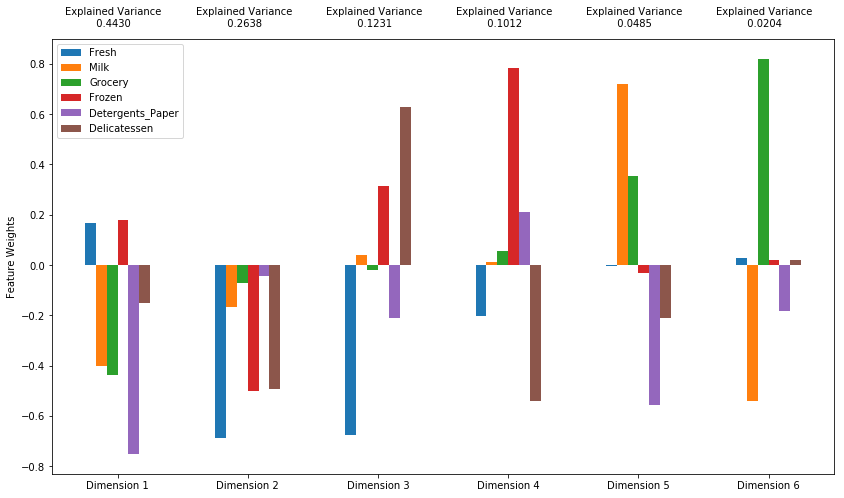

In [28]:
# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components = 6, random_state=0)
pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)
print("Explained Variance Ratio => {}\n".format(pca.explained_variance_ratio_))
print("Explained Variance Ratio(csum) => {}\n".format(pca.explained_variance_ratio_.cumsum()))

# Generate PCA results plot
pca_results = pca_results(good_data, pca)

### Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the individual feature weights.

**Answer:**

1. _How much variance in the data is explained* **in total** *by the first and second principal component?_ - (0.44302505 + 0.26379218) = 0.70681723 [70.68% of variation is covered by the first 2 principal components]
2. _How much variance in the data is explained by the first four principal components?_ - 0.93109011 [93.11% of variation is covered by the first 2 principal components]
3. _Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending._ - 
    1. PC1 - The 1st Princiapl Component captures high variance in 'Detergents_Paper' followed by 'Grocery' and 'Milk'. This first PC explains a strong correlation between these features as was observed earlier. An increase in PC1 is associated with an high purchase cost for 'Detergents_Paper' followed by 'Grocery' and 'Milk' and this could be a 'Retailer'.
    2. PC2 - The 2nd PC captures high variance in 'Fresh' followed by 'Frozen' and 'Delicatessen'. An increase in PC2 is associated with an high purchase cost for 'Fresh' followed by 'Frozen' and 'Delicatessen' and this could be a 'Cafe/Restaurant'.
    3. PC3 - The 3rd PC captures high variance in 'Fresh' followed by 'Delicatessen'. An increase in PC3 is associated with an high purchase cost for 'Fresh' followed by 'Delicatessen' and this could be a 'Cafe/Restaurant'.
    4. PC4 - The 4th PC captures high variance in 'Frozen' followed by 'Delicatessen'. An increase in PC4 is associated with an high purchase cost for 'Frozen' followed by 'Delicatessen' and this could be a 'Cafe/Restaurant'.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [29]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,1.5715,0.6914,0.7154,-0.0264,0.0495,-0.2803
1,-1.8145,-0.2029,0.7064,0.6552,-0.4010,-0.2483
2,-1.1818,-1.3883,-0.5519,-0.2136,-0.0931,0.1051


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a significant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [30]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components = 2, random_state=0)
pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [31]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,1.5715,0.6914
1,-1.8145,-0.2029
2,-1.1818,-1.3883


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

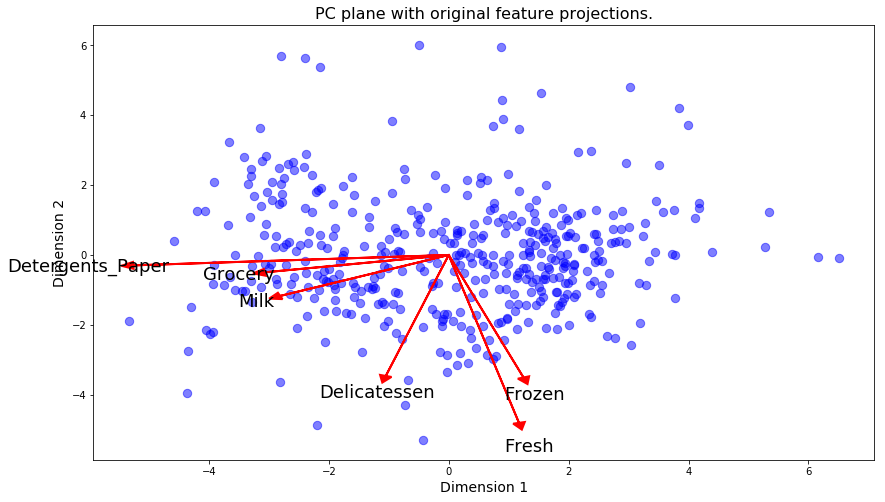

In [32]:
# Create a biplot
biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

**Answer**

From the above visualization we can see that for `Dimension 1` 'Detergents_Paper', 'Grocery' and 'Milk' are strongly correlated on the negative side. For the `Dimension 2`, 'Fresh', 'Frozen' and 'Delicatessen' are strongly correlated on the negative direction.

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

** Hint: ** Think about the differences between hard clustering and soft clustering and which would be appropriate for our dataset.

**Answer:**

1. _What are the advantages to using a K-Means clustering algorithm?_ - K-Means algorithm is used to create 'K' clusters from 'N' data values. The results generated by K-Means is usually dependent on the initial cluster centroids. The main advantages of K-Means clustering is its ease of implementation and efficient computational cost. So, it can be used for huge datasets with ease. Moreover visualization from K-Means are easier to understand.
2. _What are the advantages to using a Gaussian Mixture Model clustering algorithm?_ - Gaussian Mixture Model (GMM) is a special case of Expectation-Maximization that calculates the probability of a data point belonging to a cluster. GMM can be sued to identify complex clusters using "soft" assigment.
3. _Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?_ - As we have data with around 440 data points and 6 features we will use K-Means for simplicity. The reason we are using K-Means is that it is a general purpose algorithm and also the data is almost normally distributed after the log transformation.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [33]:
def sil_coeff(no_clusters):
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer_1 = KMeans(n_clusters=no_clusters, random_state=0 )
    clusterer_1.fit(reduced_data)
    
    # Predict the cluster for each data point
    preds_1 = clusterer_1.predict(reduced_data)
    
    # Find the cluster centers
    centers_1 = clusterer_1.cluster_centers_
    
    # Predict the cluster for each transformed sample data point
    sample_preds_1 = clusterer_1.predict(pca_samples)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds_1)
    
    print("silhouette coefficient for `{}` clusters => {:.4f}".format(no_clusters, score))
    
clusters_range = range(2,15)
for i in clusters_range:
    sil_coeff(i)

silhouette coefficient for `2` clusters => 0.4263
silhouette coefficient for `3` clusters => 0.3969
silhouette coefficient for `4` clusters => 0.3320
silhouette coefficient for `5` clusters => 0.3510
silhouette coefficient for `6` clusters => 0.3666
silhouette coefficient for `7` clusters => 0.3633
silhouette coefficient for `8` clusters => 0.3510
silhouette coefficient for `9` clusters => 0.3541
silhouette coefficient for `10` clusters => 0.3510
silhouette coefficient for `11` clusters => 0.3519
silhouette coefficient for `12` clusters => 0.3509
silhouette coefficient for `13` clusters => 0.3596
silhouette coefficient for `14` clusters => 0.3611


### Question 7

* Report the silhouette score for several cluster numbers you tried. 
* Of these, which number of clusters has the best silhouette score?

**Answer:**

1. _Report the silhouette score for several cluster numbers you tried._ - Below are the silhouette scores:
    * silhouette coefficient for `2` clusters => 0.4263
    * silhouette coefficient for `3` clusters => 0.3969
    * silhouette coefficient for `4` clusters => 0.3320
    * silhouette coefficient for `5` clusters => 0.3510
2. _Of these, which number of clusters has the best silhouette score?_ - From the above data we see that the silhouette score is highest for **2 clusters**.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

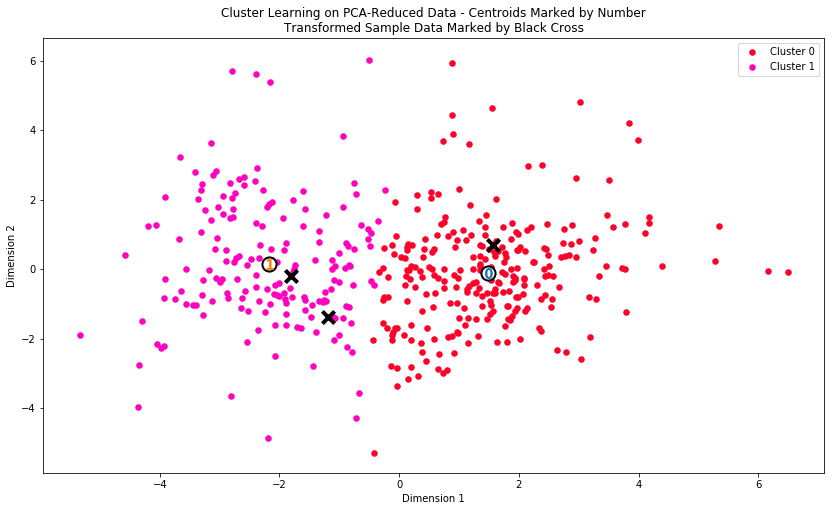

In [34]:
# Display the results of the clustering from implementation for 2 clusters
clusterer = KMeans(n_clusters = 2)
clusterer.fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_
sample_preds = clusterer.predict(pca_samples)

cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [35]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8867.0,1897.0,2477.0,2088.0,294.0,681.0
Segment 1,4005.0,7900.0,12104.0,952.0,4561.0,1036.0


In [36]:
display(data.mean(axis=0))

Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicatessen         1524.870455
dtype: float64

In [37]:
display(samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,3191,1993,1799,1730,234,710
1,2932,6459,7677,2561,4573,1386
2,20782,5921,9212,1759,2568,1553


### Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?

**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`. Think about what each segment represents in terms their values for the feature points chosen. Reference these values with the mean values to get some perspective into what kind of establishment they represent.

**Answer:**

_Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?_ - Below are my observations:

1. Segment 0 - These customers are purchasing less `Milk`, less `Grocery` and less `Detergents_Paper` than the population mean. This segment of customers tend to purchase more `Frozen/Fresh` and could be Restaurants or Hotels.
2. Segment 1 - These customers are purchasing more `Milk`, more `Grocery` and more `Detergents_Paper` than the population mean. This segment of customers tend to purchase more `Grocery/Milk/Detergents_Paper` and could be Retailers or Supermarkets.

__Other Observations__

1. Segment 0 customers are purchasing more `Fresh` than Segment 1 customers.
2. Segment 0 customers are purchasing more `Frozen` than Segment 1 customers.
3. Segment 1 customers are purchasing more `Detergents_Paper` than Segment 0 customers.
4. Segment 1 customers are purchasing more `Delicatessen` than Segment 0 customers.

### Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [38]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1


**Answer:**

1. _For each sample point, which customer segment from* **Question 8** *best represents it?_ - Below are my observations:
    1. Sample 0 - This customer purchased very less of 'Milk', 'Grocery', 'Detergents_Paper' and definitely falls in Segment 0
    2. Sample 1 - This customer purchased a lot of 'Milk', 'Grocery', 'Detergents_Paper' and falls in Segment 1
    3. Sample 2 - This customer purchased a lot of 'Milk', 'Grocery', 'Detergents_Paper' and falls in Segment 1
2. _Are the predictions for each sample point consistent with this?_ - Yes, the predictions for each of the samples are mostly consistent with our observations.(As the initial predictions from EDA are not made for just 2 segments there is a little difference with the above predictions that are made of just 2 clusters.)

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*

**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

Segment 1 customers are spending more on `Frozen` and `Fresh` and obviously they will love to get the delivery every day. So, if we change the delivery service from 5 days a week to 3 days a week, Segment 1 customers will react very badly.

If the wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week then he should first test it on Segment 0 customers and see their reaction first before he can try it out for Segment 1 customers.

For the A/B testing, the wholesale distributor should select random samples that significantly summarizes the population from Segment 0 and Segment 1. Now, the sample has to be split in to 2 groups where one of the group will act as a control group. Now, the wholesale distributor should change the delivery service from 5 days a week to 3 days a week and check what segment of people have a low satisfaction rate. This A/B testing will help the wholesale distributor to change the delivery service from 5 days a week to 3 days a week for only those segment of customers who reacted positively or who did not react negatively.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

The wholesale distributor could use a Supervised Learning algorithm to predict the customer segment category of the new users. Here, the target value will be the `Customer Segment`.

For the Supervised Learning algorithm:

    * X_train will be all the data points with all features excluding `Customer Segment`.
    * y_train will be all the data points with the feature `Customer Segment`.

    * X_test will be the new data points with all the features.

    * A model is fit on X_train and y_train and we predict the `Customer Segment` for new data points using the X_test.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

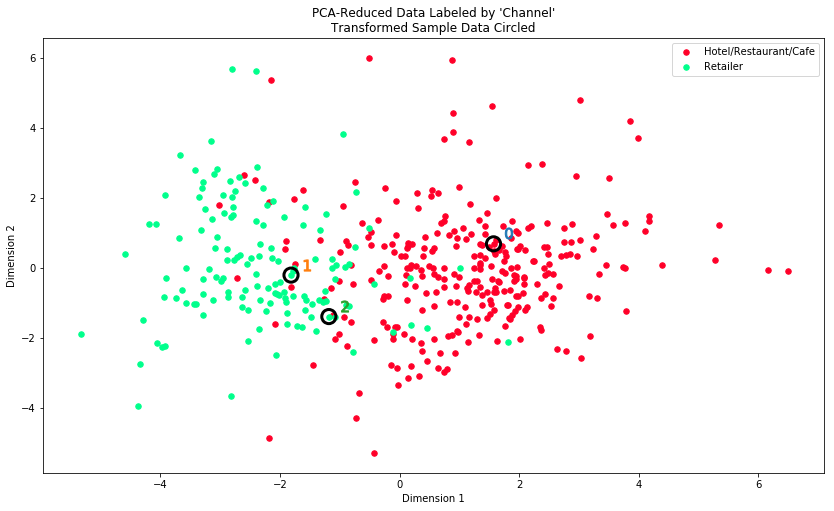

In [39]:
# Display the clustering results based on 'Channel' data
channel_results(reduced_data, outliers, pca_samples)

### Question 12

* How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
* Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
* Would you consider these classifications as consistent with your previous definition of the customer segments?

**Answer:**

1. _How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers?_ - The underlying distribution of "Hotel/Restaurant/Cafe" and "Retailer" clearly matches with the 2 customers segments that we created.
2. _Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution?_ - Yes, from the above visualization we could clearly say that those customers that are in extreme regions are well classified and are purely "Hotel/Restaurant/Cafe" or "Retailer".
3. _Would you consider these classifications as consistent with your previous definition of the customer segments?_ - Absolutely. Though there are some classifications in the center that could have been misclassified, overall these classifications are consistent with our definitions.